In [1]:
#importing in libraries
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import requests 
from io import BytesIO

In [2]:
# loading in the data required for the project, data updates each time
df = pd.read_csv('https://github.com/guga31bb/nflfastR-data/blob/master/data/play_by_play_2020.csv.gz?raw=True', compression='gzip', low_memory=False)

In [3]:
#selecting the play types that we will want for the analysis
wanted_plays = ['run', 'pass', 'no_play']

In [4]:
#making a table with only the wanted play types
off_def_plays = df[df.play_type.isin(wanted_plays)]

In [5]:
#creating a data frame to sum the EPA for each play and count number of plays
epa_df = pd.DataFrame({
    'offense_epa': off_def_plays.groupby('posteam')['epa'].sum(),
    'offense_plays': off_def_plays['posteam'].value_counts(),
    'offense_yards': off_def_plays.groupby('posteam')['yards_gained'].sum(),
})

epa_df['offense_epa/play'] = epa_df['offense_epa'] / epa_df['offense_plays']

epa_df.sort_values(by='offense_epa/play', ascending = False).head()

,offense_epa,offense_plays,offense_yards,offense_epa/play
GB,243.862752,1176,7114.0,0.207366
TEN,192.895993,1149,6575.0,0.167882
KC,212.051120,1320,7912.0,0.160645
BUF,179.567289,1276,7354.0,0.140727
TB,186.576005,1330,7679.0,0.140283


In [6]:
#entering in the EPA for the defense 
epa_df['defense_epa'] = off_def_plays.groupby('defteam')['epa'].sum()
epa_df['defense_plays'] = off_def_plays['defteam'].value_counts()
epa_df['defense_epa/play'] = epa_df['defense_epa'] / epa_df['defense_plays']
epa_df['defense_yards_given_up'] = off_def_plays.groupby('defteam')['yards_gained'].sum()

epa_df.sort_values(by = 'defense_epa/play', ascending=True).head()

,offense_epa,offense_plays,offense_yards,offense_epa/play,defense_epa,defense_plays,defense_epa/play,defense_yards_given_up
LA,-11.146089,1260,6632.0,-0.008846,-171.680614,1169,-0.146861,5286.0
PIT,30.293632,1191,5936.0,0.025435,-99.184844,1123,-0.088321,5298.0
WAS,-53.589470,1179,5477.0,-0.045453,-71.319223,1130,-0.063114,5400.0
NO,88.202257,1228,6723.0,0.071826,-56.699692,1181,-0.048010,5544.0
TB,186.576005,1330,7679.0,0.140283,-58.249313,1372,-0.042456,6647.0


Text(0.5, 1.0, 'Offense EPA and Defense EPA 2021 Season')

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


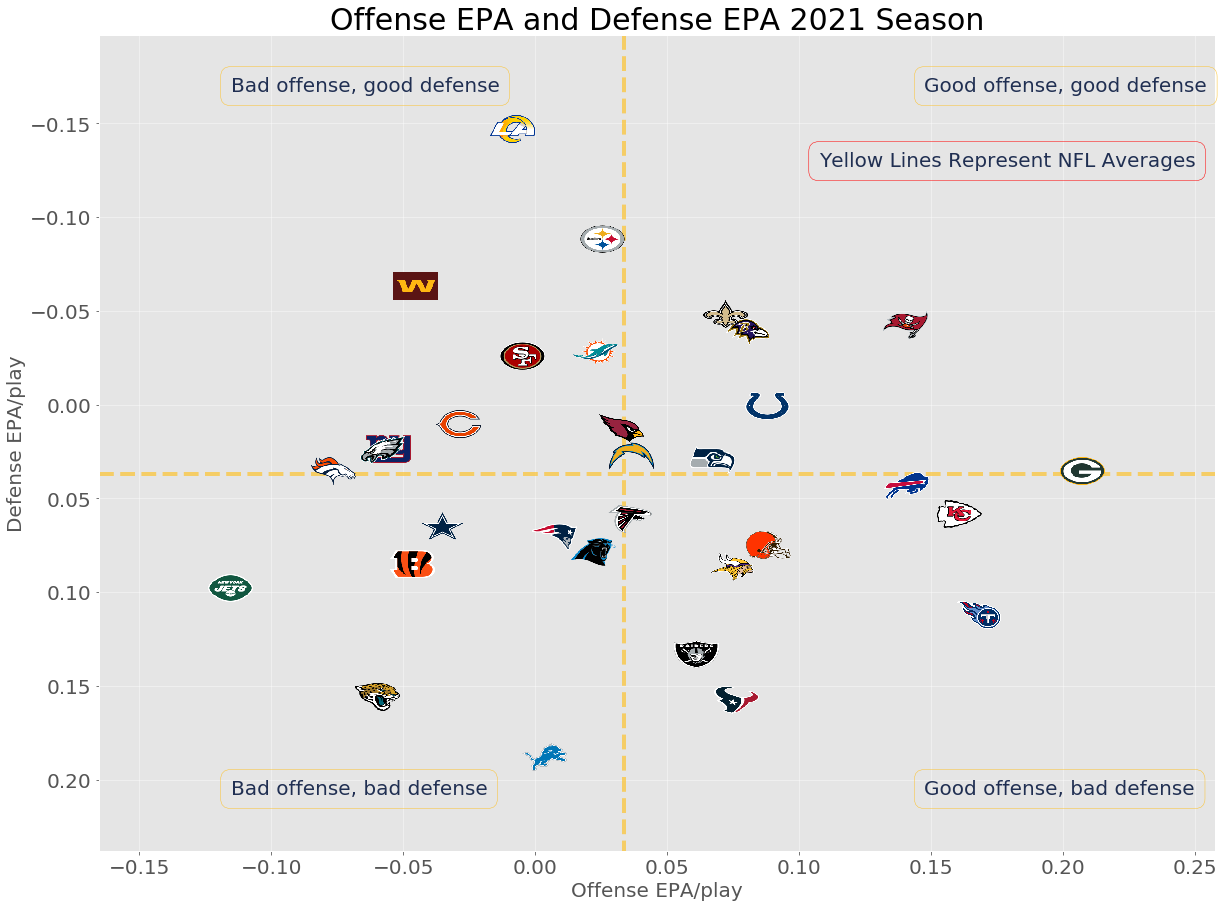

In [7]:
#Making a offense vs. defense EPA chart
plt.style.use('ggplot')
plt.rcParams["font.family"] = "Ubuntu"

x = epa_df['offense_epa/play'].values
y = epa_df['defense_epa/play'].values

fig, ax = plt.subplots(figsize=(20,15))

ax.grid(alpha = 0.5)

##Seperating the graph into quadrants
ax.vlines(np.mean(x), y.min() - 0.05, y.max() + 0.05, color = '#fcc331', alpha = 0.7, lw = 4, linestyle="dashed")
ax.hlines(np.mean(y), x.min() - 0.05, x.max() + 0.05, color = '#fcc331', alpha = 0.7, lw = 4, linestyle="dashed")
ax.set_ylim(y.min() - 0.05, y.max() + 0.05)
ax.set_xlim(x.min() - 0.05, x.max() + 0.05)
ax.set_xlabel('Offense EPA/play', fontsize=20)
ax.set_ylabel('Defense EPA/play', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().invert_yaxis()

annot_styles = {
    'bbox': {'boxstyle': 'round,pad=0.5', 'facecolor': 'none', 'edgecolor':'#fcc331'},
    'fontsize': 20,
    'color': '#202f52'
}

key_styles = {
  'bbox': {'boxstyle': 'round,pad=0.5', 'facecolor': 'none', 'edgecolor':'#FF0000'},
    'fontsize': 20,
    'color': '#202f52'  
}

##annotate the quadrants
ax.annotate('Good offense, good defense', xy=(x.max() - 0.06, y.min() - 0.02), **annot_styles)
ax.annotate('Bad offense, good defense', xy=(x.min(), y.min() - 0.02), **annot_styles)
ax.annotate('Good offense, bad defense', xy=(x.max() - 0.06, y.max() + 0.02), **annot_styles)
ax.annotate('Bad offense, bad defense', xy=(x.min(), y.max() + 0.02), **annot_styles)

#key for the lines
ax.annotate('Yellow Lines Represent NFL Averages', xy=(x.max() - 0.10, y.min() + 0.02), **key_styles)

##adding in team colors
team_colors = pd.read_csv('https://raw.githubusercontent.com/guga31bb/nflfastR-data/master/teams_colors_logos.csv')

##annotate the points with team logos
for idx, row in epa_df.iterrows():
    offense_epa = row['offense_epa/play']
    defense_epa = row['defense_epa/play']
    logo_src = team_colors[team_colors['team_abbr'] == idx]['team_logo_wikipedia'].values[0]
    res = requests.get(logo_src)
    img = plt.imread(BytesIO(res.content))
    ax.imshow(img, extent=[row['offense_epa/play'] - 0.0085, row['offense_epa/play'] + 0.0085, row['defense_epa/play'] + 0.00725, row['defense_epa/play'] - 0.00725], aspect='auto', zorder=1000)
    
ax.set_title('Offense EPA and Defense EPA 2021 Season', fontsize=30)   

In [8]:
#making the weeks label and tables to filter data by
weeks = range(1,max(off_def_plays.week)+1)

In [9]:
#creating a data frame to sum the EPA for each play and count number of plays for offense
Week_tables_off = off_def_plays.groupby(['posteam', 'week']).agg({'epa': ['sum', 'count', 'mean']}).reset_index()
#creating a data frame to sum the EPA for each play and count number of plays for defense
Week_tables_def = off_def_plays.groupby(['defteam', 'week']).agg({'epa': ['sum', 'count', 'mean']}).reset_index()

In [10]:
#Renaming the columns
Week_tables_off.columns = ['team', 'week','offense_epa', 'offense_plays', 'offense_epa_mean']              
Week_tables_def.columns = ['team', 'week','defense_epa', 'defense_plays', 'defense_epa_mean']       

In [11]:
team_name =input('Enter Team Code: ')

Enter Team Code: SEA


In [12]:
Week_table_team = pd.merge(Week_tables_off, Week_tables_def)
Week_table_team[Week_table_team.team == team_name]

,team,week,offense_epa,offense_plays,offense_epa_mean,defense_epa,defense_plays,defense_epa_mean
451,SEA,1,19.698920,64,0.307796,-1.482109,82,-0.018074
452,SEA,2,10.676905,66,0.161771,13.871971,71,0.195380
453,SEA,3,9.424014,77,0.122390,9.242355,85,0.108734
454,SEA,4,14.868578,60,0.247810,3.366278,71,0.047412
455,SEA,5,3.394317,55,0.061715,5.456040,88,0.062000
456,SEA,7,7.907881,86,0.091952,9.678948,83,0.116614
457,SEA,8,16.789770,67,0.250594,12.886811,71,0.181504
458,SEA,9,5.083260,65,0.078204,14.847117,68,0.218340
459,SEA,10,-10.363050,69,-0.150189,6.339507,69,0.091877
460,SEA,11,11.692467,67,0.174514,8.237527,71,0.116022


In [13]:
#adding other information in the table 
#team color information
for x in epa_df.index:
    epa_df.loc[x, 'team_color'] = team_colors[team_colors['team_abbr'] == x]['team_color'].values[0]
epa_df

,offense_epa,offense_plays,offense_yards,offense_epa/play,defense_epa,defense_plays,defense_epa/play,defense_yards_given_up,team_color
ARI,37.896109,1158,6173.0,0.032725,14.619502,1138,0.012847,5640.0,#97233f
ATL,40.602659,1135,5909.0,0.035773,66.689024,1087,0.061351,6388.0,#a71930
BAL,95.135387,1185,6570.0,0.080283,-46.199711,1193,-0.038726,5723.0,#241773
BUF,179.567289,1276,7354.0,0.140727,57.076533,1309,0.043603,6910.0,#00338d
CAR,23.113864,1054,5605.0,0.021930,83.576227,1062,0.078697,5781.0,#0085ca
CHI,-33.378152,1152,5556.0,-0.028974,12.109615,1164,0.010403,5918.0,#0b162a
CIN,-51.761203,1108,5124.0,-0.046716,91.250142,1070,0.085281,6243.0,#000000
CLE,106.793343,1210,6635.0,0.088259,93.561242,1248,0.074969,6751.0,#fb4f14
DAL,-41.271274,1166,5962.0,-0.035396,73.196186,1131,0.064718,6205.0,#002244
DEN,-83.342048,1089,5390.0,-0.076531,38.948631,1101,0.035376,5902.0,#002244


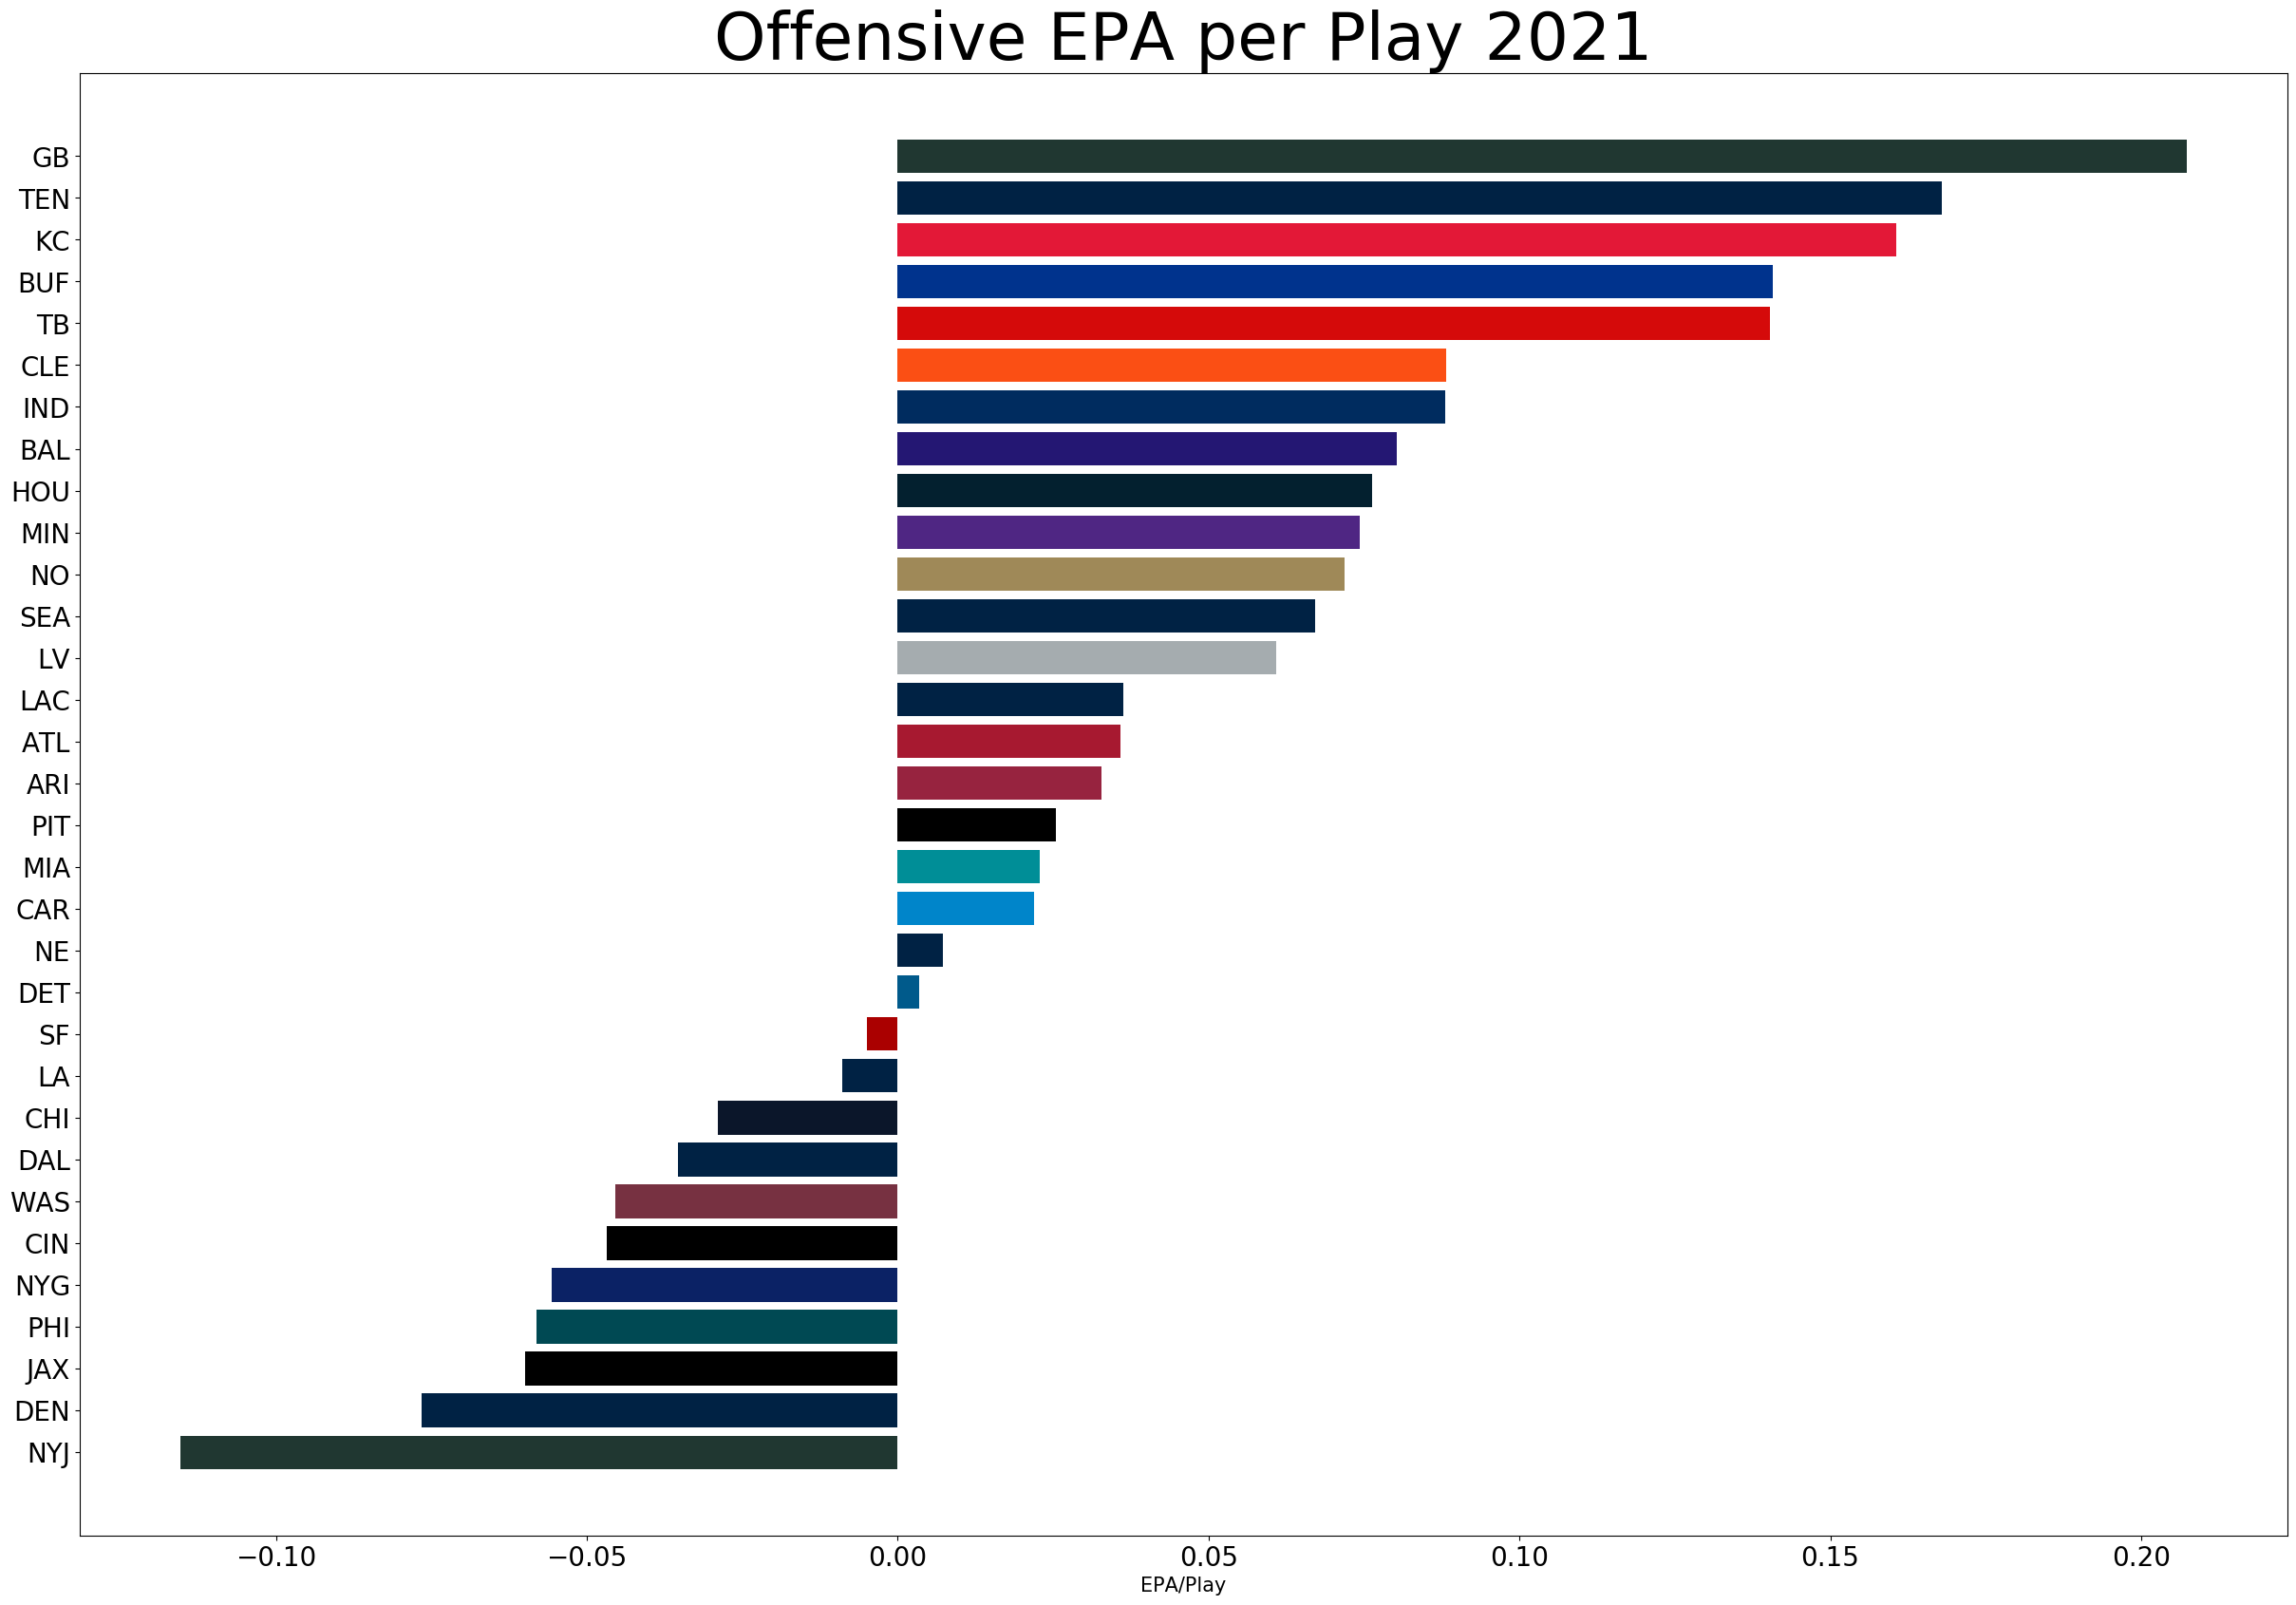

In [14]:
#creating a bar plot for all of the NFL teams offensive EPA
plt.style.use('default')


fig, ax = plt.subplots(figsize=(30,20))
plt.barh(epa_df.sort_values(by = ['offense_epa/play']).index, epa_df.sort_values(by = ['offense_epa/play'])['offense_epa/play'].values,
        color = epa_df.sort_values(by = ['offense_epa/play'])['team_color'])
ax.set_xlabel('EPA/Play', size = 15)
ax.set_title('Offensive EPA per Play 2021', size = 50)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()
    

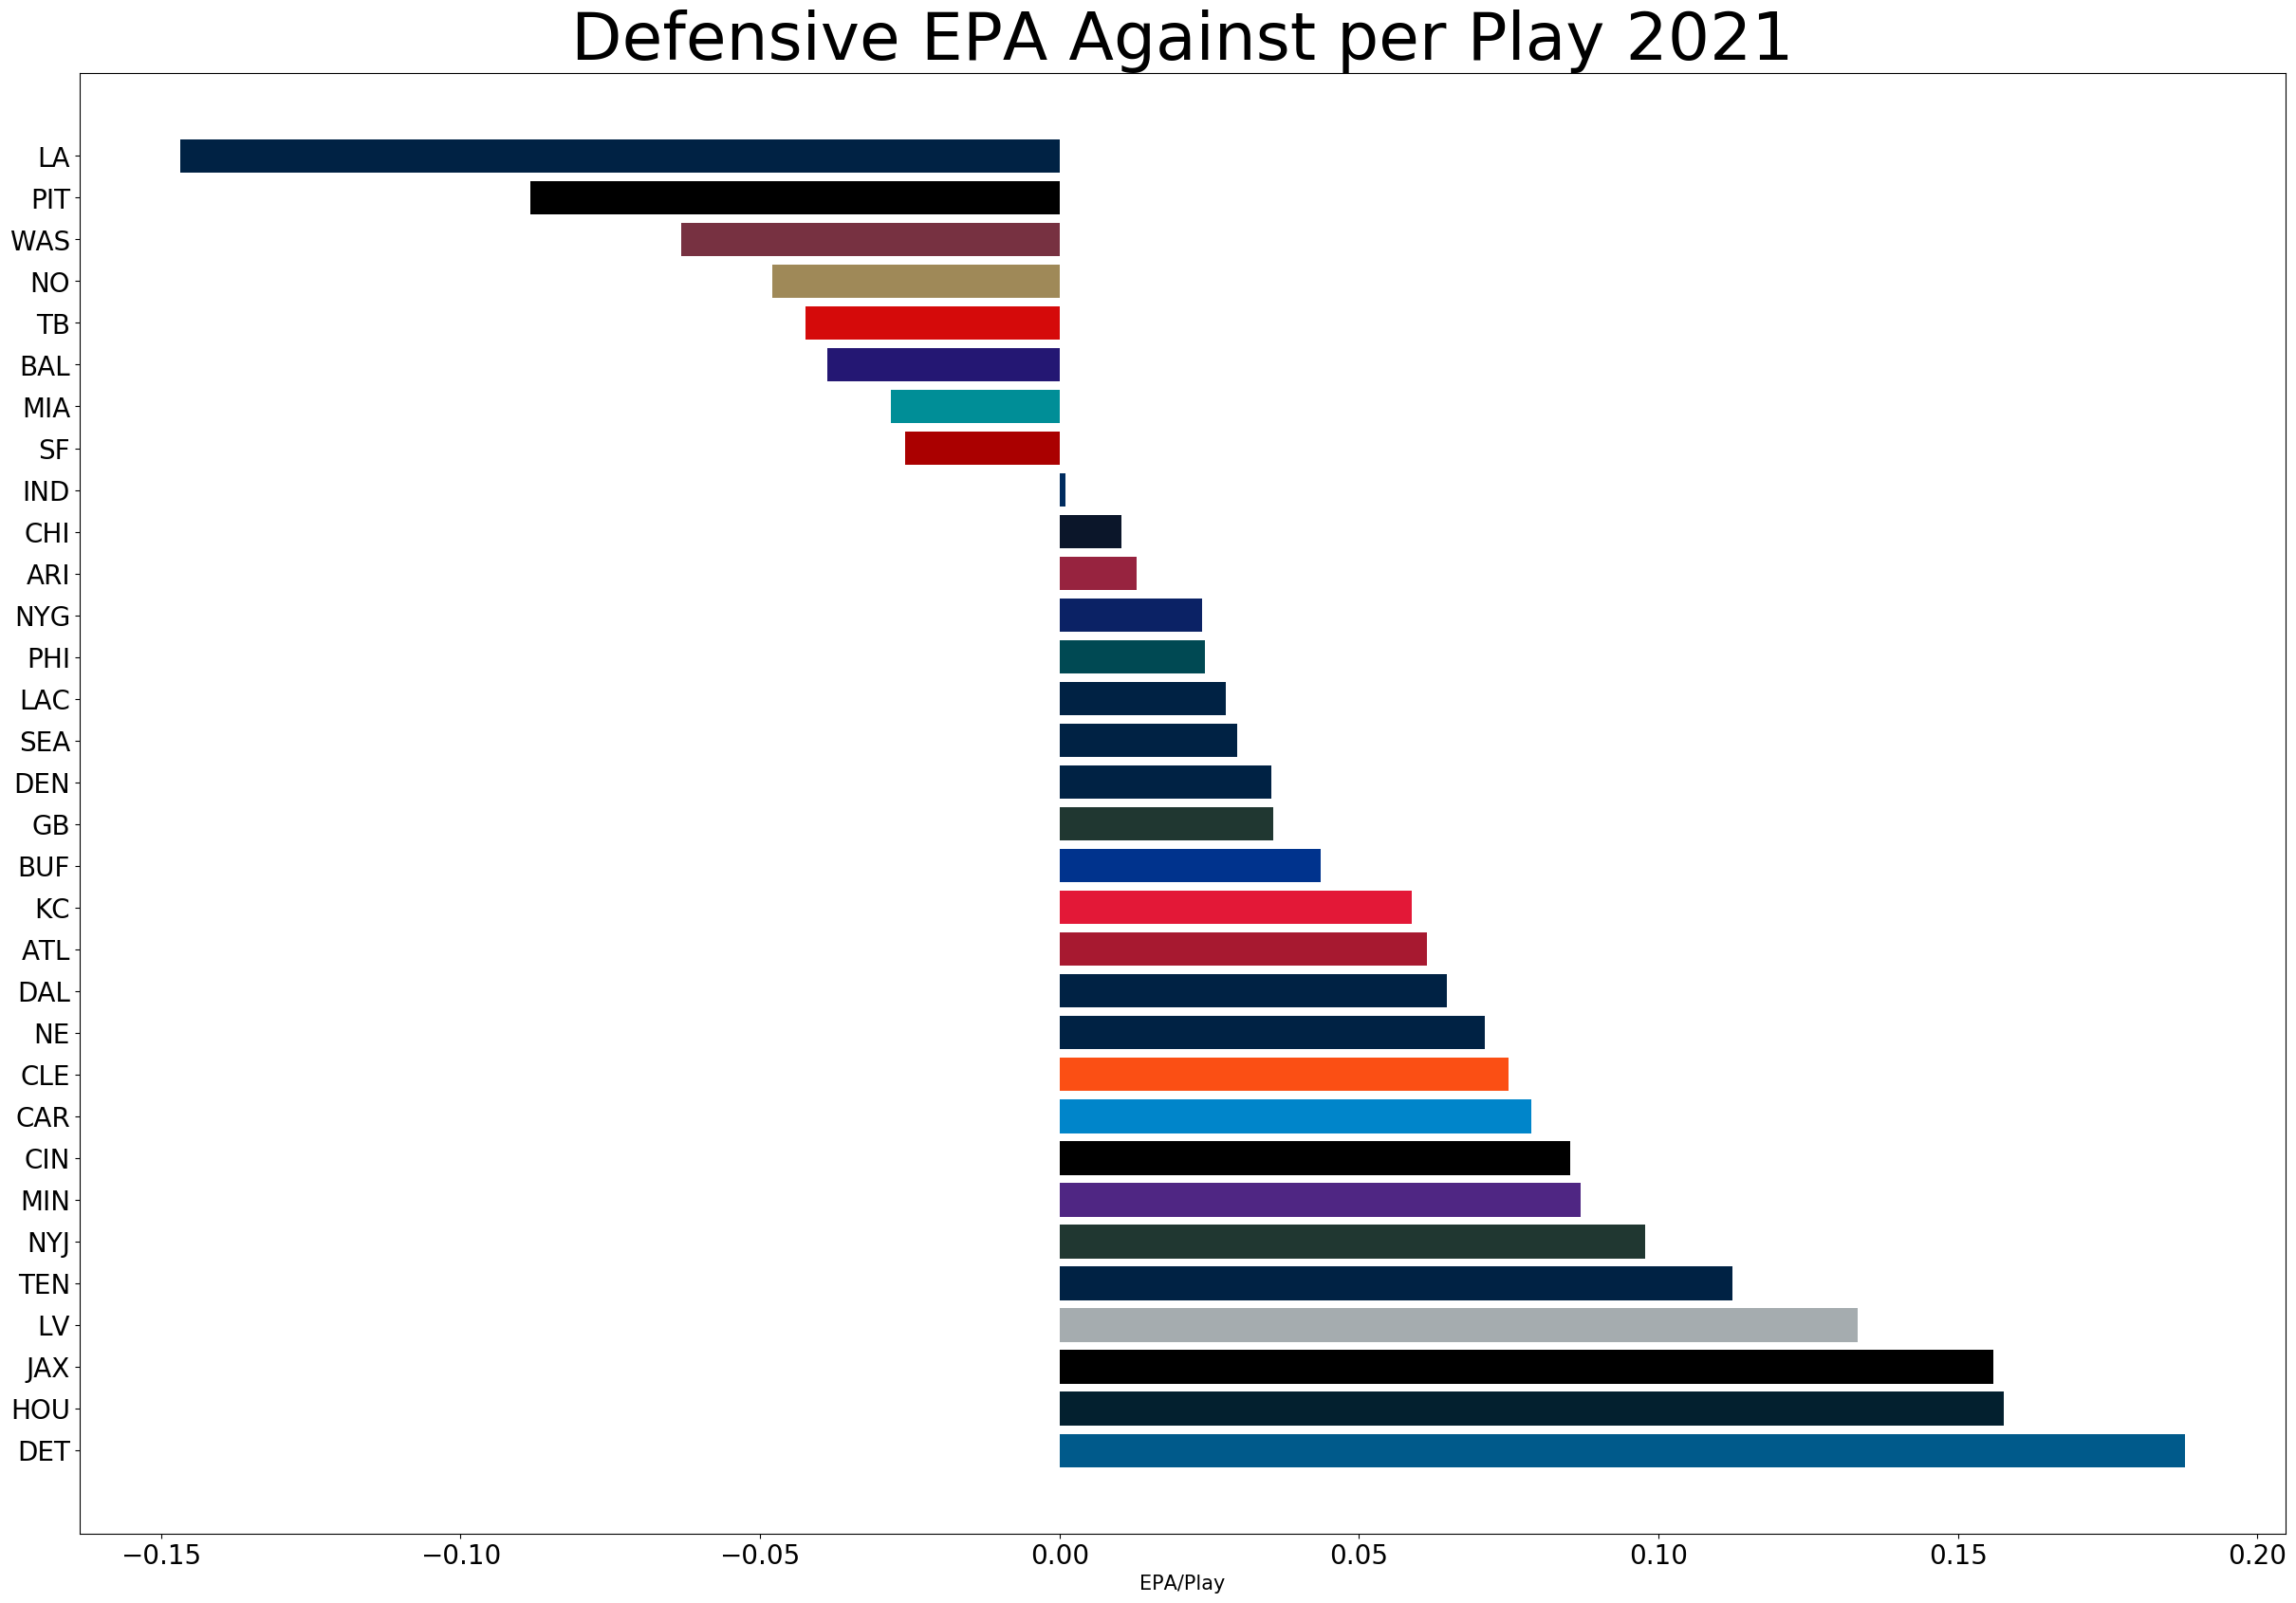

In [15]:
#creating a bar plot for all of the NFL teams defensive EPA
plt.style.use('default')
fig, ax = plt.subplots(figsize=(30,20))

plt.barh(epa_df.sort_values(by = ['defense_epa/play'], ascending = False).index, epa_df.sort_values(by = ['defense_epa/play'], ascending = False)['defense_epa/play'].values,
        color = epa_df.sort_values(by = ['defense_epa/play'], ascending = False)['team_color'])
ax.set_xlabel('EPA/Play', size = 15)
ax.set_title('Defensive EPA Against per Play 2021', size = 50)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()
    

In [16]:
epa_df

,offense_epa,offense_plays,offense_yards,offense_epa/play,defense_epa,defense_plays,defense_epa/play,defense_yards_given_up,team_color
ARI,37.896109,1158,6173.0,0.032725,14.619502,1138,0.012847,5640.0,#97233f
ATL,40.602659,1135,5909.0,0.035773,66.689024,1087,0.061351,6388.0,#a71930
BAL,95.135387,1185,6570.0,0.080283,-46.199711,1193,-0.038726,5723.0,#241773
BUF,179.567289,1276,7354.0,0.140727,57.076533,1309,0.043603,6910.0,#00338d
CAR,23.113864,1054,5605.0,0.021930,83.576227,1062,0.078697,5781.0,#0085ca
CHI,-33.378152,1152,5556.0,-0.028974,12.109615,1164,0.010403,5918.0,#0b162a
CIN,-51.761203,1108,5124.0,-0.046716,91.250142,1070,0.085281,6243.0,#000000
CLE,106.793343,1210,6635.0,0.088259,93.561242,1248,0.074969,6751.0,#fb4f14
DAL,-41.271274,1166,5962.0,-0.035396,73.196186,1131,0.064718,6205.0,#002244
DEN,-83.342048,1089,5390.0,-0.076531,38.948631,1101,0.035376,5902.0,#002244


In [17]:
x = Week_table_team[Week_table_team.team == team_name]['week'].values
y1 = Week_table_team[Week_table_team.team == team_name]['offense_epa'].values
y2 = Week_table_team[Week_table_team.team == team_name]['defense_epa'].values

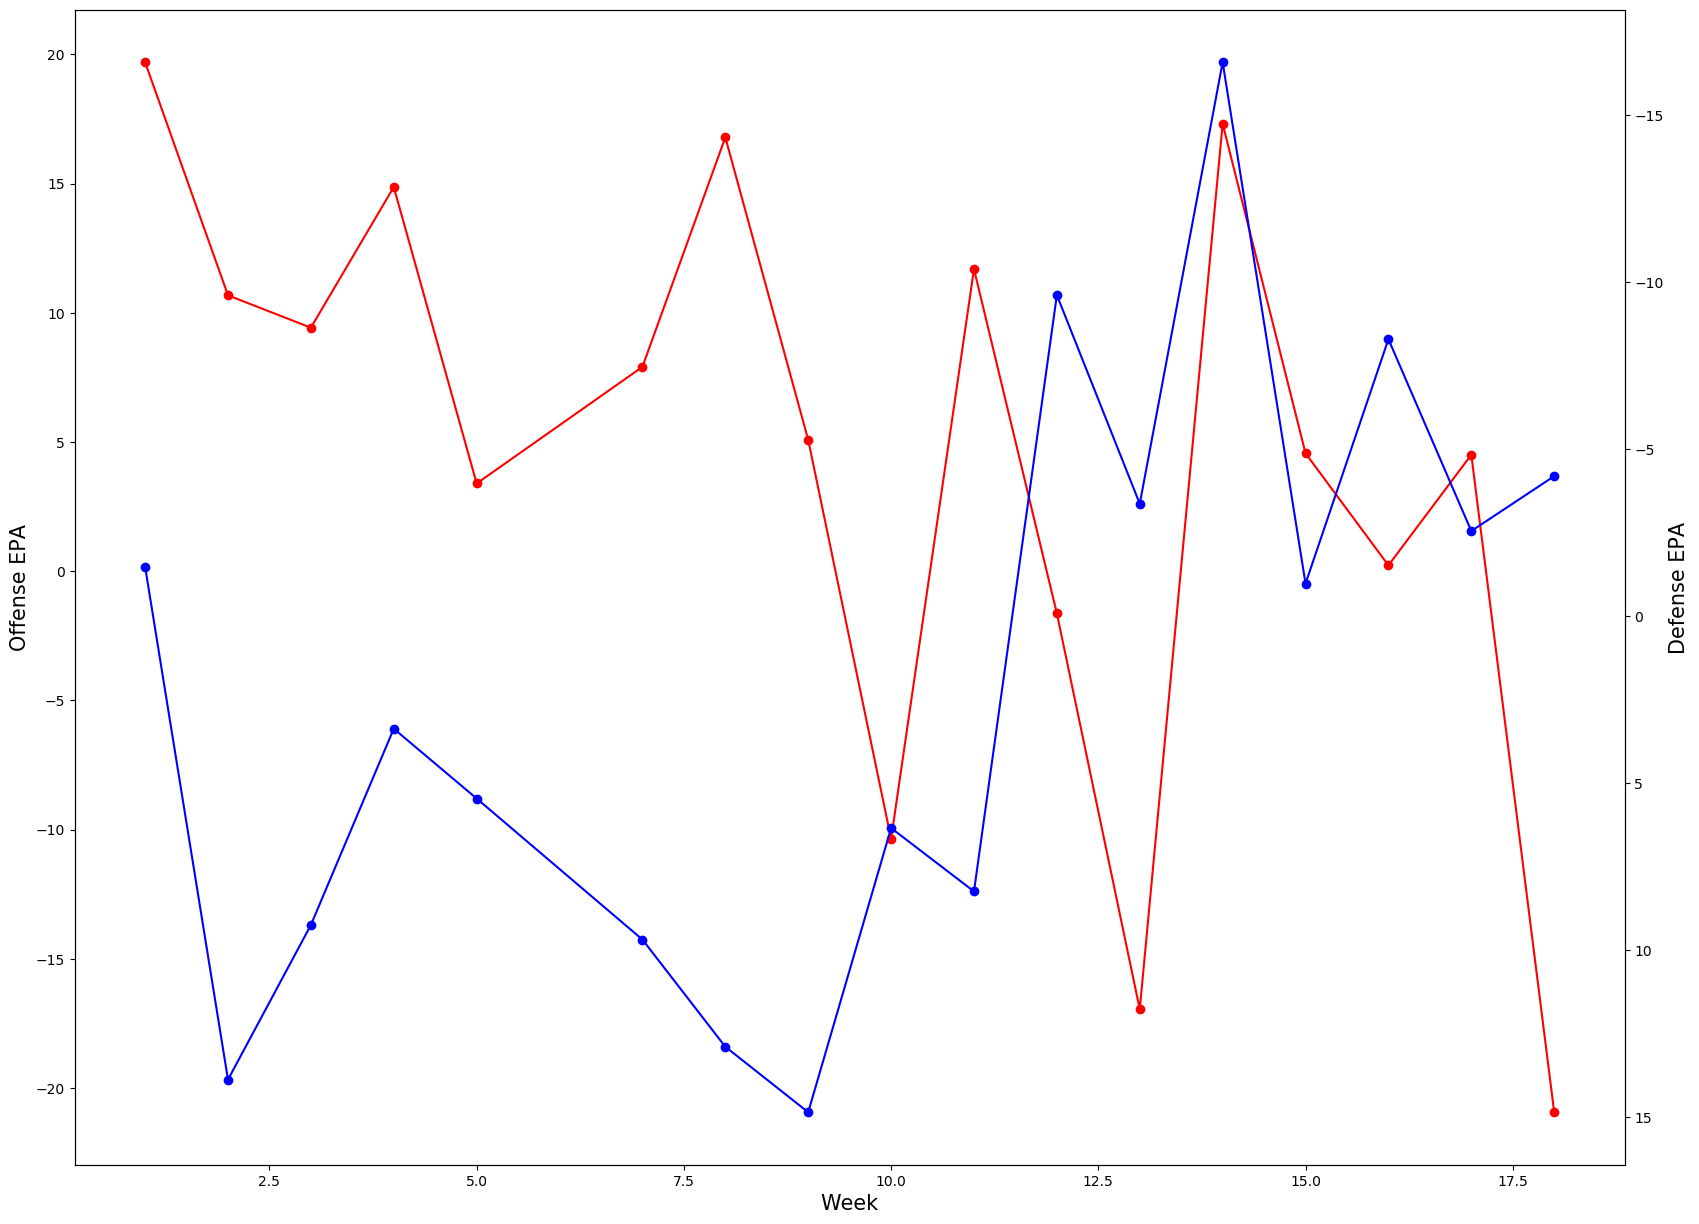

In [18]:
#create figure and axis objects for line plots
fig, ax = plt.subplots(figsize=(20,15))
#making the first plot
ax.plot(x,y1, color = 'red', marker ='o')
#set the x axis label
ax.set_xlabel("Week", fontsize = 15)
#set the y label
ax.set_ylabel('Offense EPA', fontsize = 15)

#twin object for two different y-axis on the same plot
ax2=ax.twinx()
#make a plot with different axis using second axis objkect
ax2.plot(x,y2, color='blue', marker = 'o')
ax2.set_ylabel('Defense EPA', fontsize = 15)
ax2.invert_yaxis()

plt.show()